## Cut scan: CE-like background in offspill 

SAM definition: `nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root` 

Cut combinations: 

* No within_lhr_max (loop helix maximum radius, 450 < R_max < 680 mm)
* No within_d0 	(distance of closest approach, |d_0| < 100 mm
* No within_pitch_angle (Extrapolated pitch angle (0.5577350 < tan(theta_Dip) < 1.0
* Loose within_lhr_max, R_max < 680 mm
* Loose within_pitch_angle, tan(theta_Dip) < 2.0

See ../comp/track_cuts.ipynb for cut distributions. 

## Imports

Switched to using installed pyutils package

In [1]:
import uproot
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
plt.style.use("/exp/mu2e/data/users/sgrant/mu2e.mplstyle")
import numpy as np
import hist
import gc
import sys
from datetime import datetime

from pyutils.pyprocess import Processor, Skeleton
from pyutils.pyplot import Plot
from pyutils.pyprint import Print
from pyutils.pyselect import Select
from pyutils.pyvector import Vector
from pyutils.pylogger import Logger
logger = Logger(print_prefix="[ana_cut_scan]")

sys.path.append("../common")
from cut_manager import CutManager
from analyse import Analyse, Utils
from postprocess import PostProcess

## Set file output tag

In [2]:
# Get today"s date in MM-DD-YY format
today = datetime.now().strftime("%m-%d-%y")
# tag = "test_plot" # today
tag = today
ds_type = "offspill"

# Create Processor (flexible)

Allow cut inputs in initialisation

In [3]:
# Create your custom processor class
class CosmicProcessor(Skeleton):
    """Your custom file processor 
    
    This class inherits from the Skeleton base class, which provides the 
    basic structure and methods withing the Processor framework 
    """
    def __init__(self, cuts_to_toggle):
        """Initialise your processor with specific configuration
        
        This method sets up all the parameters needed for this specific analysis.

        Args: 
            cuts_to_toggle (dict): Dict of cut name with active state  

        
        """
        # Call the parent class"s __init__ method first
        # This ensures we have all the base functionality properly set up
        super().__init__()

        # Now override parameters from the Skeleton with the ones we need
        # Data selection configuration 
        self.defname = "nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root"
        # self.file_list_path = "//exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0_24.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0_99.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/pyutils-test/TestFileLists/local_file_list.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/pyutils-test/TestFileLists/local_0.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/background_files.txt"
        # self.file_name = "nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00024906.root"
        # self.file_name = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/data/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00050440.root"
    
        self.branches = { 
            "evt" : [
                "run",
                "subrun",
                "event",
            ],
            "crv" : [
                "crvcoincs.time",
                "crvcoincs.nHits",
                "crvcoincs.pos.fCoordinates.fZ"
            ],
            "trk" : [
                "trk.nactive", 
                "trk.pdg", 
                "trkqual.valid",
                "trkqual.result"
            ],
            "trkfit" : [
                "trksegs",
                "trksegpars_lh"
            ],
            "trkmc" : [
                "trkmcsim"
            ]
        }
        self.use_remote = True     # Use remote file via mdh
        self.location = "disk"     # File location
        self.max_workers = 50      # Limit the number of workers
        self.verbosity = 2         # Set verbosity 
        self.use_processes = True  # Use processes rather than threads
        
        # Now add your own analysis-specific parameters 

        # Init analysis methods
        # Would be good to load an analysis config here 
        self.analyse = Analyse(
            # event_subrun=(93561, 25833), # select one event
            on_spill=False,
            verbosity=0
        )

        self.logger = Logger(
            print_prefix = "[CosmicProcessor]"
        )
            
        # Toggle cuts 
        self.cuts_to_toggle = cuts_to_toggle
            
        # Custom prefix for log messages from this processor
        self.logger.log(f"Initialised with {cuts_to_toggle}", "success")
        
    # ==========================================
    # Define the core processing logic
    # ==========================================
    # This method overrides the parent class"s process_file method
    # It will be called automatically for each file by the execute method
    def process_file(self, file_name): 
        """Process a single ROOT file
        
        This method will be called for each file in our list.
        It extracts data, processes it, and returns a result.
        
        Args:
            file_name: Path to the ROOT file to process
            
        Returns:
            A tuple containing the histogram (counts and bin edges)
        """
        try:
            # Create a local pyprocess Processor to extract data from this file
            # This uses the configuration parameters from our class
            this_processor = Processor(
                use_remote=self.use_remote,     # Use remote file via mdh
                location=self.location,         # File location
                verbosity=0 # self.verbosity        # Reduce output in worker threads
            )
            
            # Extract the data 
            this_data = this_processor.process_data(
                file_name = file_name, 
                branches = self.branches
            )
            
            # ---- Analysis ----            
            results = self.analyse.execute(
                this_data, 
                file_name,
                self.cuts_to_toggle
            )

            # Clean up
            gc.collect()

            return results 
        
        except Exception as e:
            # Handle any errors that occur during processing
            self.logger.log(f"Error processing {file_name}: {e}", "success")
            return None

## Run scan

In [4]:
cut_configs = [
    {"nominal" : None}, # Nominal
    {"within_lhr_max" : False}, # within_lhr_max OFF
    {"within_d0" : False}, # within_d0 OFF
    {"within_pitch_angle" : False}, # within_pitch_angle OFF
    {"within_pitch_angle" : False, "within_pitch_angle_loose" : True}, # within_pitch_angle OFF, within_pitch_angle_loose ON
    {"within_lhr_max" : False, "within_lhr_max_loose" : True}  # within_lhr_max OFF, within_lhr_max_loose ON
]

results = []
    
for i_cut, cut_config in enumerate(cut_configs): 

    # Printout 
    logger.log(f"Running cut config: {cut_config}", "info")

    if "nominal" in cut_config.keys():
        cut_config = None

    # Initalise Processor 
    cosmic_processor = CosmicProcessor(cuts_to_toggle = cut_config)

    # Execute analysis
    these_results = cosmic_processor.execute()

    # Initialise postprocessor 
    postprocessor = PostProcess()

    # Execute postprocessor
    data, hists, stats, info = postprocessor.execute(these_results)

    # Store results as a list of dicts 
    results.append({
        "config_id": i_cut,
        "config": cut_config,
        "data": data,
        "hists": hists,
        "stats": stats,
        "info": info
    })

[ana_cut_scan] ⭐️ Running cut config: {'nominal': None}
[Skeleton] ⭐️ Skeleton init
[CosmicProcessor] ✅ Initialised with None
[CosmicProcessor] ⭐️ Starting analysis
[pyutils] ⭐️ Setting up...
[pyutils] ✅ Ready
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = disk
	schema = root
	verbosity=2
[pyprocess] 👀 Loading file list for SAM definition: nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root
[pyprocess] ✅ Successfully loaded file list
	SAM definition: nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root
	Count: 817 files
[pyprocess] ⭐️ Starting processing on 817 files with 50 processes


Processing: 100%|██████████████████████████████| 817/817 [05:53<00:00,  2.31file/s, successful=817, failed=0]


[pyprocess] ⭐️ Returning 817 results
[CosmicProcessor] ✅ Analysis complete
[PostProcess] ⭐️ Initialised
[PostProcess] ✅ Combined arrays, result contains 4 events
[PostProcess] ✅ Combined 3 histograms over 817 results
[PostProcess] ✅ Combined cut statistics
[PostProcess] ✅ Postprocessing complete:
	returning tuple of combined arrays, combined histograms, and combined cut stats
[ana_cut_scan] ⭐️ Running cut config: {'within_lhr_max': False}
[Skeleton] ⭐️ Skeleton init
[CosmicProcessor] ✅ Initialised with {'within_lhr_max': False}
[CosmicProcessor] ⭐️ Starting analysis
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = disk
	schema = root
	verbosity=2
[pyprocess] 👀 Loading file list for SAM definition: nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root
[pyprocess] ✅ Successfully loaded file list
	SAM definition: nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root
	Count: 817 files

Processing: 100%|██████████████████████████████| 817/817 [07:43<00:00,  1.76file/s, successful=817, failed=0]


[pyprocess] ⭐️ Returning 817 results
[CosmicProcessor] ✅ Analysis complete
[PostProcess] ⭐️ Initialised
[PostProcess] ✅ Combined arrays, result contains 6 events
[PostProcess] ✅ Combined 3 histograms over 817 results
[PostProcess] ✅ Combined cut statistics
[PostProcess] ✅ Postprocessing complete:
	returning tuple of combined arrays, combined histograms, and combined cut stats
[ana_cut_scan] ⭐️ Running cut config: {'within_d0': False}
[Skeleton] ⭐️ Skeleton init
[CosmicProcessor] ✅ Initialised with {'within_d0': False}
[CosmicProcessor] ⭐️ Starting analysis
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = disk
	schema = root
	verbosity=2
[pyprocess] 👀 Loading file list for SAM definition: nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root
[pyprocess] ✅ Successfully loaded file list
	SAM definition: nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root
	Count: 817 files
[pyproces

Processing: 100%|██████████████████████████████| 817/817 [08:18<00:00,  1.64file/s, successful=817, failed=0]


[pyprocess] ⭐️ Returning 817 results
[CosmicProcessor] ✅ Analysis complete
[PostProcess] ⭐️ Initialised
[PostProcess] ✅ Combined arrays, result contains 495 events
[PostProcess] ✅ Combined 3 histograms over 817 results
[PostProcess] ✅ Combined cut statistics
[PostProcess] ✅ Postprocessing complete:
	returning tuple of combined arrays, combined histograms, and combined cut stats
[ana_cut_scan] ⭐️ Running cut config: {'within_pitch_angle': False}
[Skeleton] ⭐️ Skeleton init
[CosmicProcessor] ✅ Initialised with {'within_pitch_angle': False}
[CosmicProcessor] ⭐️ Starting analysis
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = disk
	schema = root
	verbosity=2
[pyprocess] 👀 Loading file list for SAM definition: nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root
[pyprocess] ✅ Successfully loaded file list
	SAM definition: nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root
	Count:

Processing: 100%|██████████████████████████████| 817/817 [08:07<00:00,  1.68file/s, successful=817, failed=0]  


[pyprocess] ⭐️ Returning 817 results
[CosmicProcessor] ✅ Analysis complete
[PostProcess] ⭐️ Initialised
[PostProcess] ✅ Combined arrays, result contains 24 events
[PostProcess] ✅ Combined 3 histograms over 817 results
[PostProcess] ✅ Combined cut statistics
[PostProcess] ✅ Postprocessing complete:
	returning tuple of combined arrays, combined histograms, and combined cut stats
[ana_cut_scan] ⭐️ Running cut config: {'within_pitch_angle': False, 'within_pitch_angle_loose': True}
[Skeleton] ⭐️ Skeleton init
[CosmicProcessor] ✅ Initialised with {'within_pitch_angle': False, 'within_pitch_angle_loose': True}
[CosmicProcessor] ⭐️ Starting analysis
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = disk
	schema = root
	verbosity=2
[pyprocess] 👀 Loading file list for SAM definition: nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root
[pyprocess] ✅ Successfully loaded file list
	SAM definition: nts.mu2e.CosmicCRYSigna

Processing: 100%|██████████████████████████████| 817/817 [08:33<00:00,  1.59file/s, successful=817, failed=0]


[pyprocess] ⭐️ Returning 817 results
[CosmicProcessor] ✅ Analysis complete
[PostProcess] ⭐️ Initialised
[PostProcess] ✅ Combined arrays, result contains 24 events
[PostProcess] ✅ Combined 3 histograms over 817 results
[PostProcess] ✅ Combined cut statistics
[PostProcess] ✅ Postprocessing complete:
	returning tuple of combined arrays, combined histograms, and combined cut stats
[ana_cut_scan] ⭐️ Running cut config: {'within_lhr_max': False, 'within_lhr_max_loose': True}
[Skeleton] ⭐️ Skeleton init
[CosmicProcessor] ✅ Initialised with {'within_lhr_max': False, 'within_lhr_max_loose': True}
[CosmicProcessor] ⭐️ Starting analysis
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = disk
	schema = root
	verbosity=2
[pyprocess] 👀 Loading file list for SAM definition: nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root
[pyprocess] ✅ Successfully loaded file list
	SAM definition: nts.mu2e.CosmicCRYSignalAllOffSpillTrig

Processing: 100%|██████████████████████████████| 817/817 [08:54<00:00,  1.53file/s, successful=817, failed=0]  


[pyprocess] ⭐️ Returning 817 results
[CosmicProcessor] ✅ Analysis complete
[PostProcess] ⭐️ Initialised
[PostProcess] ✅ Combined arrays, result contains 5 events
[PostProcess] ✅ Combined 3 histograms over 817 results
[PostProcess] ✅ Combined cut statistics
[PostProcess] ✅ Postprocessing complete:
	returning tuple of combined arrays, combined histograms, and combined cut stats


## Analyse results

### Cut statisics 

In [65]:
results[1]

{'config_id': 1,
 'config': {'within_lhr_max': False},
 'data': <Array [{evt: {...}, crv: {...}, ...}, ...] type='7 * {evt: {event: int32, ...'>,
 'hists': {'Wide range': Hist(
    Regular(30, 0, 300, name='momentum', label='Momentum [MeV/c]'),
    StrCategory(['All', 'CE-like', 'Unvetoed CE-like'], name='selection', label='Selection'),
    storage=Double()) # Sum: 8627142.0 (8687305.0 with flow),
  'Signal region': Hist(
    Regular(13, 103.6, 104.9, name='momentum', label='Momentum [MeV/c]'),
    StrCategory(['All', 'CE-like', 'Unvetoed CE-like'], name='selection', label='Selection'),
    storage=Double()) # Sum: 65980.0 (65982.0 with flow),
  'CRV z-position': Hist(
    Regular(100, -15000, 10000, name='crv_z', label='CRV z-position [mm]'),
    StrCategory(['All', 'CE-like', 'Unvetoed CE-like'], name='selection', label='Selection'),
    storage=Double()) # Sum: 6398325.0},
 'stats': [{'name': 'No cuts',
   'active': 'N/A',
   'description': 'No selection applied',
   'events_passing

In [5]:
cut_manager = CutManager()

# def get_cut_stats_df(stats, out_path=f"../../txt/{ds_type}/{ds_type}_cut_stats_{today}.csv"):
#     df_stats = cut_manager.get_cut_stats(stats=stats, active_only=True, printout=False)
#     df_stats.to_csv(out_path, index=False)
#     print(df_stats)
#     logger.log(f"Wrote {out_path}", "success")
#     return df_stats

# for result in enumerate(cut_configs): 
#     df_stats = get_cut_stats_df()

In [6]:
def get_cut_stats_df(stats, config_id, cut_config, out_path=None):
    
    df_stats = cut_manager.get_cut_stats(stats=stats, active_only=True, printout=False)
    
    # Add cut config information to the dataframe
    df_stats["Cut Config ID"] = config_id
    df_stats["Cut Config"] = str(cut_config) 
    
    if out_path:
        df_stats.to_csv(out_path, index=False)
        logger.log(f"Wrote {out_path}", "success")
    
    return df_stats

# Create separate dataframes for each config
cut_stats_dfs = {}

for result in results:  
    
    config_name = f"config_{result["config_id"]}"
    
    # Create individual output path
    out_path = f"../../txt/{ds_type}/cut_scan/{ds_type}_cut_stats_{config_name}_{today}.csv"
    
    df_stats = get_cut_stats_df(
        stats=result["stats"], 
        config_id=result["config_id"], 
        cut_config=result["config"],
        out_path=out_path
    )
    
    # Store in dictionary
    cut_stats_dfs[config_name] = df_stats
    
    # Display individual dataframe
    logger.log(f"Stats for {config_name}", "info")
    display(df_stats)

# Also create combined dataframe, just because why not
df_stats_combined = pd.concat(cut_stats_dfs.values(), ignore_index=True)

# Save the combined dataframe
combined_out_path = f"../../txt/{ds_type}/cut_scan/{ds_type}_cut_scan_stats_combined_{today}.csv"
df_stats_combined.to_csv(combined_out_path, index=False)
logger.log(f"Wrote combined stats to {combined_out_path}", "success")

[CutManager] ✅ Created cut statistics DataFrame 
[ana_cut_scan] ✅ Wrote ../../txt/offspill/cut_scan/offspill_cut_stats_config_0_07-01-25.csv
[ana_cut_scan] ⭐️ Stats for config_0


,Cut,Active,Events Passing,Absolute Frac. [%],Relative Frac. [%],Description,Cut Config ID,Cut Config
0,No cuts,N/A,5754129,100.00,100.00,No selection applied,0,None
1,is_truth_electron,True,2319356,40.31,40.31,Track parents are electrons (truth PID),0,None
2,is_reco_electron,True,2136407,37.13,92.11,Tracks are assumed to be electrons (trk),0,None
3,one_reco_electron,True,1396453,24.27,65.36,One reco electron / event,0,None
4,good_trkqual,True,517715,9.00,37.07,Track quality (quality > 0.8),0,None
5,downstream,True,411001,7.14,79.39,Downstream tracks (p_z > 0 through tracker),0,None
6,has_hits,True,410417,7.13,99.86,Minimum of 20 active hits in the tracker,0,None
7,within_lhr_max,True,300273,5.22,73.16,Loop helix maximum radius (450 < R_max < 680 mm),0,None
8,within_d0,True,41548,0.72,13.84,Distance of closest approach (d_0 < 100 mm),0,None
9,within_pitch_angle,True,18914,0.33,45.52,Extrapolated pitch angle (0.5577350 < tan(thet...,0,None


[CutManager] ✅ Created cut statistics DataFrame 
[ana_cut_scan] ✅ Wrote ../../txt/offspill/cut_scan/offspill_cut_stats_config_1_07-01-25.csv
[ana_cut_scan] ⭐️ Stats for config_1


,Cut,Active,Events Passing,Absolute Frac. [%],Relative Frac. [%],Description,Cut Config ID,Cut Config
0,No cuts,N/A,5754129,100.00,100.00,No selection applied,1,{'within_lhr_max': False}
1,is_truth_electron,True,2319356,40.31,40.31,Track parents are electrons (truth PID),1,{'within_lhr_max': False}
2,is_reco_electron,True,2136407,37.13,92.11,Tracks are assumed to be electrons (trk),1,{'within_lhr_max': False}
3,one_reco_electron,True,1396453,24.27,65.36,One reco electron / event,1,{'within_lhr_max': False}
4,good_trkqual,True,517715,9.00,37.07,Track quality (quality > 0.8),1,{'within_lhr_max': False}
5,downstream,True,411001,7.14,79.39,Downstream tracks (p_z > 0 through tracker),1,{'within_lhr_max': False}
6,has_hits,True,410417,7.13,99.86,Minimum of 20 active hits in the tracker,1,{'within_lhr_max': False}
7,within_d0,True,56712,0.99,13.82,Distance of closest approach (d_0 < 100 mm),1,{'within_lhr_max': False}
8,within_pitch_angle,True,27142,0.47,47.86,Extrapolated pitch angle (0.5577350 < tan(thet...,1,{'within_lhr_max': False}
9,unvetoed,True,7,0.00,0.03,No veto: |dt| >= 150 ns,1,{'within_lhr_max': False}


[CutManager] ✅ Created cut statistics DataFrame 
[ana_cut_scan] ✅ Wrote ../../txt/offspill/cut_scan/offspill_cut_stats_config_2_07-01-25.csv
[ana_cut_scan] ⭐️ Stats for config_2


,Cut,Active,Events Passing,Absolute Frac. [%],Relative Frac. [%],Description,Cut Config ID,Cut Config
0,No cuts,N/A,5754129,100.00,100.00,No selection applied,2,{'within_d0': False}
1,is_truth_electron,True,2319356,40.31,40.31,Track parents are electrons (truth PID),2,{'within_d0': False}
2,is_reco_electron,True,2136407,37.13,92.11,Tracks are assumed to be electrons (trk),2,{'within_d0': False}
3,one_reco_electron,True,1396453,24.27,65.36,One reco electron / event,2,{'within_d0': False}
4,good_trkqual,True,517715,9.00,37.07,Track quality (quality > 0.8),2,{'within_d0': False}
5,downstream,True,411001,7.14,79.39,Downstream tracks (p_z > 0 through tracker),2,{'within_d0': False}
6,has_hits,True,410417,7.13,99.86,Minimum of 20 active hits in the tracker,2,{'within_d0': False}
7,within_lhr_max,True,300273,5.22,73.16,Loop helix maximum radius (450 < R_max < 680 mm),2,{'within_d0': False}
8,within_pitch_angle,True,92403,1.61,30.77,Extrapolated pitch angle (0.5577350 < tan(thet...,2,{'within_d0': False}
9,unvetoed,True,759,0.01,0.82,No veto: |dt| >= 150 ns,2,{'within_d0': False}


[CutManager] ✅ Created cut statistics DataFrame 
[ana_cut_scan] ✅ Wrote ../../txt/offspill/cut_scan/offspill_cut_stats_config_3_07-01-25.csv
[ana_cut_scan] ⭐️ Stats for config_3


,Cut,Active,Events Passing,Absolute Frac. [%],Relative Frac. [%],Description,Cut Config ID,Cut Config
0,No cuts,N/A,5754129,100.00,100.00,No selection applied,3,{'within_pitch_angle': False}
1,is_truth_electron,True,2319356,40.31,40.31,Track parents are electrons (truth PID),3,{'within_pitch_angle': False}
2,is_reco_electron,True,2136407,37.13,92.11,Tracks are assumed to be electrons (trk),3,{'within_pitch_angle': False}
3,one_reco_electron,True,1396453,24.27,65.36,One reco electron / event,3,{'within_pitch_angle': False}
4,good_trkqual,True,517715,9.00,37.07,Track quality (quality > 0.8),3,{'within_pitch_angle': False}
5,downstream,True,411001,7.14,79.39,Downstream tracks (p_z > 0 through tracker),3,{'within_pitch_angle': False}
6,has_hits,True,410417,7.13,99.86,Minimum of 20 active hits in the tracker,3,{'within_pitch_angle': False}
7,within_lhr_max,True,300273,5.22,73.16,Loop helix maximum radius (450 < R_max < 680 mm),3,{'within_pitch_angle': False}
8,within_d0,True,41548,0.72,13.84,Distance of closest approach (d_0 < 100 mm),3,{'within_pitch_angle': False}
9,unvetoed,True,25,0.00,0.06,No veto: |dt| >= 150 ns,3,{'within_pitch_angle': False}


[CutManager] ✅ Created cut statistics DataFrame 
[ana_cut_scan] ✅ Wrote ../../txt/offspill/cut_scan/offspill_cut_stats_config_4_07-01-25.csv
[ana_cut_scan] ⭐️ Stats for config_4


,Cut,Active,Events Passing,Absolute Frac. [%],Relative Frac. [%],Description,Cut Config ID,Cut Config
0,No cuts,N/A,5754129,100.00,100.00,No selection applied,4,"{'within_pitch_angle': False, 'within_pitch_an..."
1,is_truth_electron,True,2319356,40.31,40.31,Track parents are electrons (truth PID),4,"{'within_pitch_angle': False, 'within_pitch_an..."
2,is_reco_electron,True,2136407,37.13,92.11,Tracks are assumed to be electrons (trk),4,"{'within_pitch_angle': False, 'within_pitch_an..."
3,one_reco_electron,True,1396453,24.27,65.36,One reco electron / event,4,"{'within_pitch_angle': False, 'within_pitch_an..."
4,good_trkqual,True,517715,9.00,37.07,Track quality (quality > 0.8),4,"{'within_pitch_angle': False, 'within_pitch_an..."
5,downstream,True,411001,7.14,79.39,Downstream tracks (p_z > 0 through tracker),4,"{'within_pitch_angle': False, 'within_pitch_an..."
6,has_hits,True,410417,7.13,99.86,Minimum of 20 active hits in the tracker,4,"{'within_pitch_angle': False, 'within_pitch_an..."
7,within_lhr_max,True,300273,5.22,73.16,Loop helix maximum radius (450 < R_max < 680 mm),4,"{'within_pitch_angle': False, 'within_pitch_an..."
8,within_d0,True,41548,0.72,13.84,Distance of closest approach (d_0 < 100 mm),4,"{'within_pitch_angle': False, 'within_pitch_an..."
9,within_pitch_angle_loose,True,41527,0.72,99.95,Extrapolated pitch angle (tan(theta_Dip) < 2.0),4,"{'within_pitch_angle': False, 'within_pitch_an..."


[CutManager] ✅ Created cut statistics DataFrame 
[ana_cut_scan] ✅ Wrote ../../txt/offspill/cut_scan/offspill_cut_stats_config_5_07-01-25.csv
[ana_cut_scan] ⭐️ Stats for config_5


,Cut,Active,Events Passing,Absolute Frac. [%],Relative Frac. [%],Description,Cut Config ID,Cut Config
0,No cuts,N/A,5754129,100.00,100.00,No selection applied,5,"{'within_lhr_max': False, 'within_lhr_max_loos..."
1,is_truth_electron,True,2319356,40.31,40.31,Track parents are electrons (truth PID),5,"{'within_lhr_max': False, 'within_lhr_max_loos..."
2,is_reco_electron,True,2136407,37.13,92.11,Tracks are assumed to be electrons (trk),5,"{'within_lhr_max': False, 'within_lhr_max_loos..."
3,one_reco_electron,True,1396453,24.27,65.36,One reco electron / event,5,"{'within_lhr_max': False, 'within_lhr_max_loos..."
4,good_trkqual,True,517715,9.00,37.07,Track quality (quality > 0.8),5,"{'within_lhr_max': False, 'within_lhr_max_loos..."
5,downstream,True,411001,7.14,79.39,Downstream tracks (p_z > 0 through tracker),5,"{'within_lhr_max': False, 'within_lhr_max_loos..."
6,has_hits,True,410417,7.13,99.86,Minimum of 20 active hits in the tracker,5,"{'within_lhr_max': False, 'within_lhr_max_loos..."
7,within_lhr_max_loose,True,307761,5.35,74.99,Loop helix maximum radius (R_max < 680 mm),5,"{'within_lhr_max': False, 'within_lhr_max_loos..."
8,within_d0,True,47990,0.83,15.59,Distance of closest approach (d_0 < 100 mm),5,"{'within_lhr_max': False, 'within_lhr_max_loos..."
9,within_pitch_angle,True,22744,0.40,47.39,Extrapolated pitch angle (0.5577350 < tan(thet...,5,"{'within_lhr_max': False, 'within_lhr_max_loos..."


[ana_cut_scan] ✅ Wrote combined stats to ../../txt/offspill/cut_scan/offspill_cut_scan_stats_combined_07-01-25.csv


In [7]:
# def get_cut_stats_df(stats, config_id, cut_config, out_path=None):
    
#     df_stats = cut_manager.get_cut_stats(stats=stats, active_only=True, printout=False)
    
#     # Add cut config information to the dataframe
#     df_stats["Cut Config ID"] = config_id
#     df_stats["Cut Config"] = str(cut_config) 
    
#     # print(df_stats)
#     logger.log(f"Wrote {out_path}", "success")
    
#     return df_stats

# # Collect all dataframes
# all_cut_stats_dfs = []

# for result in results:  
    
#     df_stats = get_cut_stats_df(
#         stats=result['stats'], 
#         config_id=result['config_id'], 
#         cut_config=result['config']
#     )
    
#     all_cut_stats_dfs.append(df_stats)

# # Combine all dataframes
# df_stats = pd.concat(all_cut_stats_dfs, ignore_index=True)
# display(df_stats)

# # Save the combined dataframe
# out_path = f"../../txt/{ds_type}/{ds_type}_cut_scan_stats_{today}.csv"
# df_stats.to_csv(out_path, index=False)
# logger.log(f"Wrote combined stats to {out_path}", "success")

## Efficiency 

In [8]:
utils = Utils()

def get_eff_df(df_stats, ce_row_name=None, out_path=None):
    df_eff = utils.get_eff(df_stats, ce_row_name=ce_row_name, veto=True)
    if out_path:
        df_eff.to_csv(out_path, index=False)
        logger.log(f"Wrote {out_path}", "success")
    return df_eff

# Create efficiency dataframes for each config
eff_dfs = {}

for config_name, df_stats in cut_stats_dfs.items():
    
    logger.log(f"Efficiency for {config_name}", "info")
    
    # Create individual output path
    out_path = f"../../txt/{ds_type}/cut_scan/{ds_type}_efficiency_{config_name}_{today}.csv"

    # Find the CE-like row (penultimate row name)
    ce_row_name = df_stats.iloc[-2]["Cut"]
    
    # # Get efficiency for this specific config
    df_eff = get_eff_df(df_stats, ce_row_name, out_path)
    
    # Store in dictionary
    eff_dfs[config_name] = df_eff
    
    # Display the efficiency table
    # display(df_eff)

# Also create a combined efficiency dataframe with config info
all_eff_dfs = []
for i, (config_name, df_eff) in enumerate(eff_dfs.items()):
    df_eff_copy = df_eff.copy()
    df_eff_copy["Config ID"] = i
    all_eff_dfs.append(df_eff_copy)

df_eff_combined = pd.concat(all_eff_dfs, ignore_index=True)

# Save combined efficiency
combined_out_path = f"../../txt/{ds_type}/cut_scan/{ds_type}_efficiency_all_configs_{today}.csv"
df_eff_combined.to_csv(combined_out_path, index=False)
logger.log(f"Wrote combined efficiency to {combined_out_path}", "success")

logger.log("Combined efficiency results:", "info")
display(df_eff_combined)

[pyprint] ⭐️ Initialised Print with verbose = True and precision = 1
[PostProcess] ⭐️ Initialised
[ana_cut_scan] ⭐️ Efficiency for config_0
[PostProcess] ⭐️ Getting efficiency with ce_row_name = within_pitch_angle and veto = True
[PostProcess] ✅ Returning efficiency information
[ana_cut_scan] ✅ Wrote ../../txt/offspill/cut_scan/offspill_efficiency_config_0_07-01-25.csv
[ana_cut_scan] ⭐️ Efficiency for config_1
[PostProcess] ⭐️ Getting efficiency with ce_row_name = within_pitch_angle and veto = True
[PostProcess] ✅ Returning efficiency information
[ana_cut_scan] ✅ Wrote ../../txt/offspill/cut_scan/offspill_efficiency_config_1_07-01-25.csv
[ana_cut_scan] ⭐️ Efficiency for config_2
[PostProcess] ⭐️ Getting efficiency with ce_row_name = within_pitch_angle and veto = True
[PostProcess] ✅ Returning efficiency information
[ana_cut_scan] ✅ Wrote ../../txt/offspill/cut_scan/offspill_efficiency_config_2_07-01-25.csv
[ana_cut_scan] ⭐️ Efficiency for config_3
[PostProcess] ⭐️ Getting efficiency wi

,Type,Events Passing (k),Total Events (N),Efficiency [%],Efficiency Error [%],Config ID
0,Signal,18914,5754129,0.328703,0.002390,0
1,Veto,5,18914,99.973565,0.011822,0
2,Signal,27142,5754129,0.471696,0.002863,1
3,Veto,7,27142,99.974210,0.009748,1
4,Signal,92403,5754129,1.605856,0.005283,2
5,Veto,759,92403,99.178598,0.029815,2
6,Signal,41548,5754129,0.722055,0.003542,3
7,Veto,25,41548,99.939829,0.012034,3
8,Signal,41527,5754129,0.721690,0.003541,4
9,Veto,25,41527,99.939798,0.012040,4


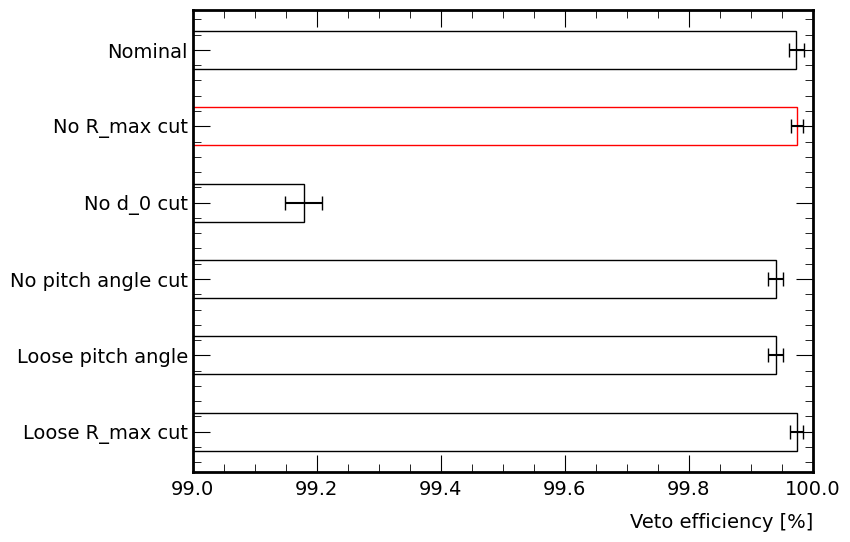

[ana_cut_scan] ✅ Wrote ../../img/offspill/cut_scan/bar_veto_efficiency_07-01-25.png


In [39]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

def eff_bar(df_eff, title=None, xlabel=None, ylabel=None, out_path="veto_efficiency.png", bar_alpha=1.0, bar_color="black", NDPI=300):
    """
    Create a horizontal bar chart for veto efficiency across different cut configurations
    """
    
    # # Filter for veto rows only
    # veto_data = df_eff[df_eff["Type"] == "Veto"].copy()
    # # Sort by Config ID
    # veto_data = veto_data.sort_values("Config ID")
    
    # # Extract data for plotting
    # config_ids = veto_data["Config ID"].values
    # efficiencies = veto_data["Efficiency [%]"].values
    # errors = veto_data["Efficiency Error [%]"].values

    # Filter for veto rows only
    veto_data = df_eff[df_eff["Type"] == "Veto"].copy()
    # Sort by Config ID in descending order to invert the bars
    veto_data = veto_data.sort_values("Config ID", ascending=False)
    
    # Extract data for plotting
    config_ids = veto_data["Config ID"].values
    efficiencies = veto_data["Efficiency [%]"].values
    errors = veto_data["Efficiency Error [%]"].values
    
    # Create descriptive labels for y-axis based on cut configurations
    cut_labels = {
        0: "Nominal",           # No within_lhr_max
        1: "No R_max cut",           # No within_lhr_max
        2: "No d_0 cut",             # No within_d0  
        3: "No pitch angle cut",     # No within_pitch_angle
        4: "Loose pitch angle",      # Loose within_pitch_angle
        5: "Loose R_max cut"         # Loose within_lhr_max
    }
    
    labels = [cut_labels.get(int(cid), f"Config {int(cid)}") for cid in config_ids]
    
    plt.style.use("../../../EventNtuple/utils/pyutils/mu2e.mplstyle")
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figure size for horizontal layout
    
    # Plot horizontal bar chart
    indices = np.arange(len(labels))
    n_bars = len(indices)
    bar_height = 3.0 / n_bars
    if n_bars == 3.0: 
        bar_height = 2.0 / n_bars
    elif n_bars == 2.0:
        bar_height = 1.0 / n_bars

    # Find the index of the highest efficiency
    max_idx = np.argmax(efficiencies)
    
    # Create color list - different color for max efficiency
    bar_colors = ["red" if i == max_idx else bar_color for i in range(len(efficiencies))]
    
    # # Plot horizontal bars with different colors
    # bars = ax.barh(indices, efficiencies, align="center", alpha=bar_alpha, color=bar_colors, 
    #                height=bar_height, fill=False, hatch="/", linewidth=1, edgecolor="black",
    #                xerr=errors, capsize=5)

    # Plot horizontal bars with error bars
    bars = ax.barh(indices, efficiencies, align="center", alpha=bar_alpha, color=bar_colors, 
                   height=bar_height, fill=False,  edgecolor=bar_colors,
                   xerr=errors, capsize=5)

    # bars = ax.barh(indices, efficiencies, align="center", alpha=bar_alpha,  
    #                height=bar_height, linewidth=1, 
    #                xerr=errors, capsize=5)
    
    # Set y-axis labels (now the categories)
    ax.set_yticks(indices)
    ax.set_yticklabels(labels, rotation=0)
    
    # Set labels for the chart (swap x and y)
    if title:
        ax.set_title(title, fontsize=16, pad=10)
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=14, labelpad=10)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=14, labelpad=10)
    
    # Set font size of tick labels on x and y axes
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    
    # Format x-axis if values are large
    if ax.get_xlim()[1] > 999:
        ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
        ax.xaxis.offsetText.set_fontsize(14)
    
    # Set x-axis to show full range (since these are percentages close to 100%)
    ax.set_xlim(99.0, 100.0)  # Adjust as needed based on your data
    
    # Save the figure
    plt.savefig(out_path, dpi=NDPI, bbox_inches="tight")
    plt.show()
    logger.log(f"Wrote {out_path}", "success")
    
eff_bar(
    df_eff_combined,
    xlabel="Veto efficiency [%]",  # Swapped from ylabel
    out_path=f"../../img/{ds_type}/cut_scan/bar_veto_efficiency_{today}.png"
)

## Retreive background event info 

In [9]:
results[0]

{'config_id': 0,
 'config': None,
 'data': <Array [{evt: {...}, crv: {...}, ...}, ...] type='5 * {evt: {event: int32, ...'>,
 'hists': {'Wide range': Hist(
    Regular(30, 0, 300, name='momentum', label='Momentum [MeV/c]'),
    StrCategory(['All', 'CE-like', 'Unvetoed CE-like'], name='selection', label='Selection'),
    storage=Double()) # Sum: 8618912.0 (8679075.0 with flow),
  'Signal region': Hist(
    Regular(13, 103.6, 104.9, name='momentum', label='Momentum [MeV/c]'),
    StrCategory(['All', 'CE-like', 'Unvetoed CE-like'], name='selection', label='Selection'),
    storage=Double()) # Sum: 65866.0 (65868.0 with flow),
  'CRV z-position': Hist(
    Regular(100, -15000, 10000, name='crv_z', label='CRV z-position [mm]'),
    StrCategory(['All', 'CE-like', 'Unvetoed CE-like'], name='selection', label='Selection'),
    storage=Double()) # Sum: 6388578.0},
 'stats': [{'name': 'No cuts',
   'active': 'N/A',
   'description': 'No selection applied',
   'events_passing': 5754129,
   'absol

In [13]:
#FIXME ak.Array(result["filtered_data"]) TypeError: string indices must be integers, not 'str'

# Create background info for each config
background_info = {}

for config_name, result in zip(cut_stats_dfs.keys(), results):
    logger.log(f"Processing background events for {config_name}", "info")

    if len(result["data"]) == 0: 
        logger.log(f"No background events, skipping {config_name}", "warning")
        continue

    # print(result)
    # # General background info
    # general_out_path = f"../../txt/{ds_type}/cut_scan/{ds_type}_background_event_info_{config_name}_{today}.txt"
    # utils.get_background_events(
    #     result,  # or however you access the results from your stored data
    #     printout=True, 
    #     out_path=general_out_path
    # )
    
    # # Verbose background info, if there are any        
    # verbose_out_path = f"../../txt/{ds_type}/cut_scan/{ds_type}_verbose_background_event_info_{config_name}_{today}.txt"
    # utils.get_verbose_background_events(
    #     result["data"], 
    #     out_path=verbose_out_path
    # )

logger.log("Background event analysis complete for all configs", "success")

[ana_cut_scan] ⭐️ Processing background events for config_0
[ana_cut_scan] ⭐️ Processing background events for config_1
[ana_cut_scan] ⭐️ Processing background events for config_2
[ana_cut_scan] ⭐️ Processing background events for config_3
[ana_cut_scan] ⭐️ Processing background events for config_4
[ana_cut_scan] ⭐️ Processing background events for config_5
[ana_cut_scan] ✅ Background event analysis complete for all configs


## Draw histograms 

Momentum and z-position

In [ ]:
# data

### Momentum plots

Needs some thought. What's a good way to overlay them?

In [45]:
# def mom_plots(hists, config_name, out_path=None):
#     if out_path is None:
#         out_path = f"../../img/{ds_type}/cut_scan/h1_ana_mom_{ds_type}_{config_name}_{today}.png"
    
#     # Now you can plot them
#     fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))
    
#     # Plot wide range in first subplot
#     h_wide = hists["Wide range"]
#     # Can also include "CE-like tracks"
#     # h_wide = h_wide[{"selection": ["All", "CE-like", "Unvetoed CE-like"]}] # slice(-2, None)}]  # Last 2 selections
#     h_wide.plot1d(overlay="selection", ax=ax[0])
#     # h_wide.sum().value
#     ax[0].set_title("Wide range")
#     ax[0].set_yscale("log")
#     ax[0].grid(True, alpha=0.3)
#     # ax[0].legend(frameon=False, loc="best")

#     # Plot signal region in second subplot
#     h_signal = hists["Signal region"]
    
#     # h_signal = h_signal[{"selection": ["All", "CE-like", "Unvetoed CE-like"]}] 
#     h_signal.plot1d(overlay="selection", ax=ax[1])
#     ax[1].set_title("Signal region: 103.6-104.9 MeV/c")
#     ax[1].set_yscale("log")
#     ax[1].grid(True, alpha=0.3)
#     ax[1].set_ylabel("")  # Remove duplicate y-label
#     ax[1].legend(frameon=False, loc="best")
    
#     plt.tight_layout()
#     plt.savefig(out_path, dpi=300)
#     plt.show()
#     logger.log(f"Wrote {out_path}", "success")

# # Create momentum plots for each config
# for config_name, result in zip(cut_stats_dfs.keys(), results):
#     logger.log(f"Creating momentum plots for {config_name}", "info")
    
#     out_path = f"../../img/{ds_type}/cut_scan/h1_ana_mom_{ds_type}_{config_name}_{today}.png"
#     mom_plots(result["hists"], config_name, out_path)

# logger.log("Momentum plots complete for all configs", "success")

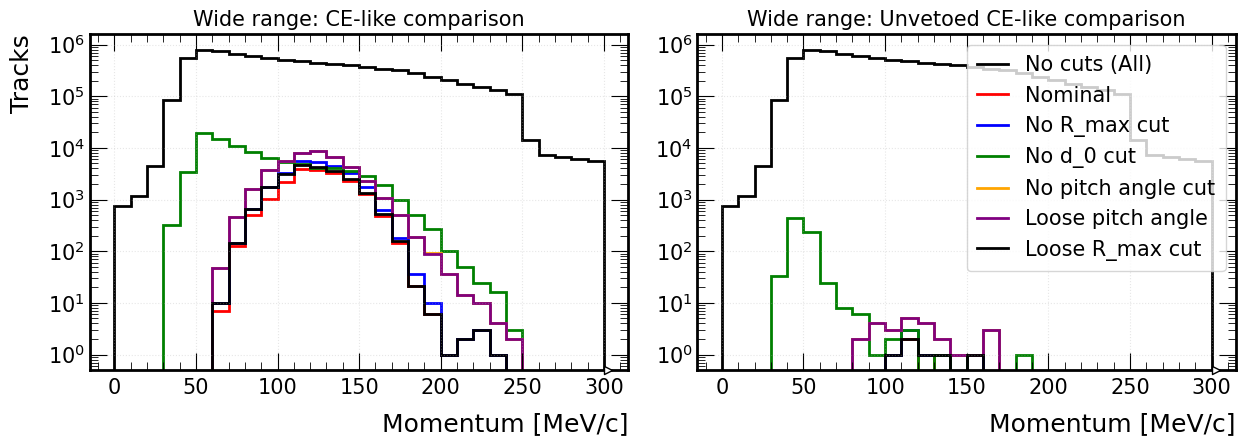

[ana_cut_scan] ✅ Wrote ../../img/offspill/cut_scan/h1_ana_mom_offspill_comparison_07-01-25.png


In [63]:
def mom_plots_comparison(all_hists_dict, out_path=None):
    
    # Create figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))
    
    # Colors for different configs
    colors = ["black", "red", "blue", "green", "orange", "purple"]
    
    # Create descriptive labels for y-axis based on cut configurations
    cut_labels = {
        0: "Nominal",           # No within_lhr_max
        1: "No R_max cut",           # No within_lhr_max
        2: "No d_0 cut",             # No within_d0  
        3: "No pitch angle cut",     # No within_pitch_angle
        4: "Loose pitch angle",      # Loose within_pitch_angle
        5: "Loose R_max cut"         # Loose within_lhr_max
    }
    
    # First plot "All" selection from the first config (baseline/no cuts)
    first_config = list(all_hists_dict.keys())[0]
    h_wide_baseline = all_hists_dict[first_config]["Wide range"][{"selection": "All"}]
    h_wide_baseline.plot1d(ax=ax[0], color="black", label="No cuts (All)", linewidth=2)
    h_wide_baseline.plot1d(ax=ax[1], color="black", label="No cuts (All)", linewidth=2)
    
    # Plot CE-like for each config on left subplot
    for i, (config_id, hists) in enumerate(all_hists_dict.items()):
        h_wide = hists["Wide range"]
        h_ce_like = h_wide[{"selection": "CE-like"}]
        
        label = cut_labels.get(config_id, f"Config {config_id}")
        color = colors[(i + 1) % len(colors)]  # Offset by 1 since black is used for baseline
        
        h_ce_like.plot1d(ax=ax[0], color=color, label=label, linewidth=2)
    
    # Plot Unvetoed CE-like for each config on right subplot  
    for i, (config_id, hists) in enumerate(all_hists_dict.items()):
        h_wide = hists["Wide range"]
        h_unvetoed = h_wide[{"selection": "Unvetoed CE-like"}]
        
        label = cut_labels.get(config_id, f"Config {config_id}")
        color = colors[(i + 1) % len(colors)]  # Same colors as left plot
        
        h_unvetoed.plot1d(ax=ax[1], color=color, label=label, linewidth=2)
    
    # Configure left subplot (CE-like)
    ax[0].set_title("Wide range: CE-like comparison")
    ax[0].set_yscale("log")
    ax[0].grid(True, alpha=0.3)
    # ax[0].legend(frameon=False, loc="best")
    ax[0].set_xlabel("Momentum [MeV/c]")
    ax[0].set_ylabel("Tracks")
    
    # Configure right subplot (Unvetoed CE-like)
    ax[1].set_title("Wide range: Unvetoed CE-like comparison")
    ax[1].set_yscale("log")
    ax[1].grid(True, alpha=0.3)
    ax[1].legend(frameon=True, loc="upper right")
    ax[1].set_xlabel("Momentum [MeV/c]")
    ax[1].set_ylabel("")  # Remove duplicate y-label

    if out_path is not None:
        plt.tight_layout()
        plt.savefig(out_path, dpi=300)
    plt.show()
    logger.log(f"Wrote {out_path}", "success")

# Collect all histograms from each config (if not already done)
all_hists_dict = {}
for config_name, result in zip(cut_stats_dfs.keys(), results):
    config_id = result["config_id"]
    all_hists_dict[config_id] = result["hists"]

# Create comparison plot
mom_plots_comparison(
    all_hists_dict,
    out_path=f"../../img/{ds_type}/cut_scan/h1_ana_mom_{ds_type}_comparison_{today}.png"
)

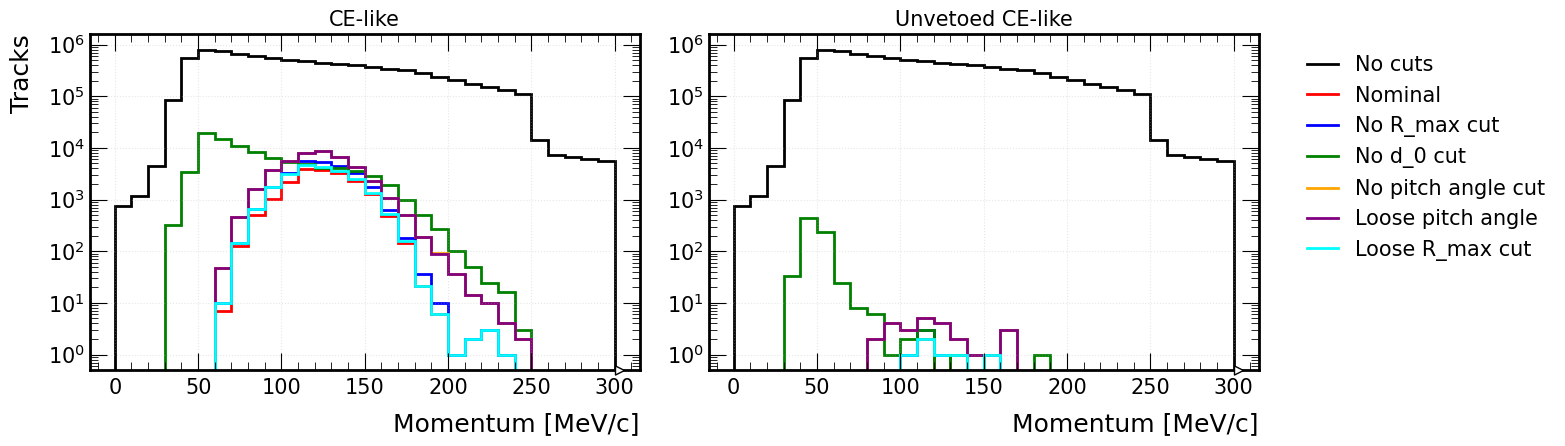

[ana_cut_scan] ✅ Wrote ../../img/offspill/cut_scan/h1_ana_mom_offspill_comparison_07-01-25.png


In [59]:
def mom_plots_comparison(all_hists_dict, out_path=None):
    if out_path is None:
        out_path = f"../../img/{ds_type}/cut_scan/h1_ana_mom_{ds_type}_comparison_{today}.png"
    
    # Create figure with two subplots - adjust figsize to accommodate legend
    fig, ax = plt.subplots(1, 2, figsize=(6.4*2.5, 4.8))  # Made wider for legend space
    
    # Colors for different configs
    colors = ["black", "red", "blue", "green", "orange", "purple", "cyan"]
    
    # Create descriptive labels for y-axis based on cut configurations
    cut_labels = {
        0: "Nominal",           # No within_lhr_max
        1: "No R_max cut",           # No within_lhr_max
        2: "No d_0 cut",             # No within_d0  
        3: "No pitch angle cut",     # No within_pitch_angle
        4: "Loose pitch angle",      # Loose within_pitch_angle
        5: "Loose R_max cut"         # Loose within_lhr_max
    }
    
    # First plot "All" selection from the first config (baseline/no cuts)
    first_config = list(all_hists_dict.keys())[0]
    h_wide_baseline = all_hists_dict[first_config]["Wide range"][{"selection": "All"}]
    h_wide_baseline.plot1d(ax=ax[0], color="black", label="No cuts", linewidth=2)
    h_wide_baseline.plot1d(ax=ax[1], color="black", label="No cuts", linewidth=2)
    
    # Plot CE-like for each config on left subplot
    for i, (config_id, hists) in enumerate(all_hists_dict.items()):
        h_wide = hists["Wide range"]
        h_ce_like = h_wide[{"selection": "CE-like"}]
        
        label = cut_labels.get(config_id, f"Config {config_id}")
        color = colors[(i + 1) % len(colors)]  # Offset by 1 since black is used for baseline
        
        h_ce_like.plot1d(ax=ax[0], color=color, label=label, linewidth=2)
    
    # Plot Unvetoed CE-like for each config on right subplot  
    for i, (config_id, hists) in enumerate(all_hists_dict.items()):
        h_wide = hists["Wide range"]
        h_unvetoed = h_wide[{"selection": "Unvetoed CE-like"}]
        
        label = cut_labels.get(config_id, f"Config {config_id}")
        color = colors[(i + 1) % len(colors)]  # Same colors as left plot
        
        h_unvetoed.plot1d(ax=ax[1], color=color, label=label, linewidth=2)
    
    # Configure left subplot (CE-like)
    ax[0].set_title("CE-like")
    ax[0].set_yscale("log")
    ax[0].grid(True, alpha=0.3)
    ax[0].set_xlabel("Momentum [MeV/c]")
    ax[0].set_ylabel("Tracks")
    
    # Configure right subplot (Unvetoed CE-like)
    ax[1].set_title("Unvetoed CE-like")
    ax[1].set_yscale("log")
    ax[1].grid(True, alpha=0.3)
    ax[1].set_xlabel("Momentum [MeV/c]")
    ax[1].set_ylabel("")  # Remove duplicate y-label
    
    # Put legend to the right of the plots
    ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
    
    plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches='tight')  # bbox_inches='tight' ensures legend is included
    plt.show()
    logger.log(f"Wrote {out_path}", "success")

# Create comparison plot
mom_plots_comparison(
    all_hists_dict,
    out_path=f"../../img/{ds_type}/cut_scan/h1_ana_mom_{ds_type}_comparison_{today}.png"
)

### z-position plots

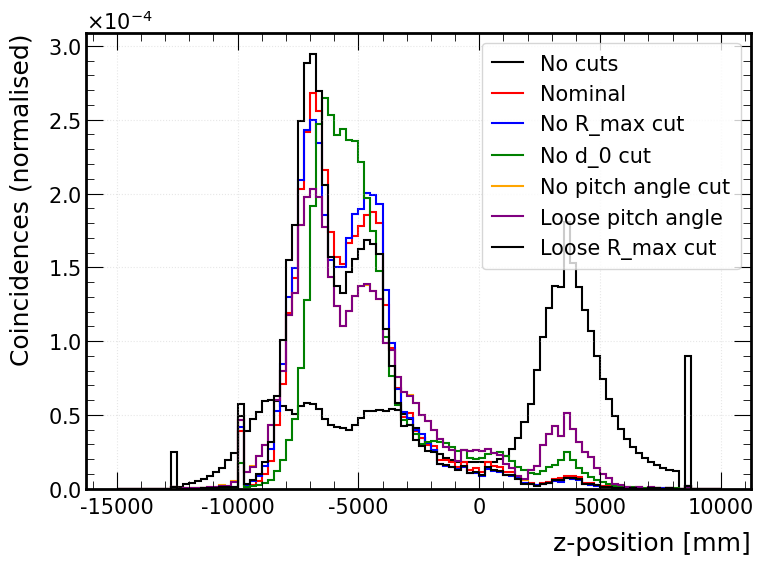

[ana_cut_scan] ✅ Wrote ../../img/offspill/cut_scan/h1_ana_crv_z_offspill_comparison_07-01-25.png


In [44]:
def z_plots_comparison(all_hists_dict, norm=True, out_path=None):
    if out_path is None:
        out_path = f"../../img/{ds_type}/cut_scan/h1_ana_crv_z_{ds_type}_comparison_{today}.png"
    
    fig, ax = plt.subplots(figsize=(6.4*1.25, 4.8*1.25))
    
    # Colors for different configs
    colors = ["black", "red", "blue", "green", "orange", "purple", "cyan"]

    cut_labels = [
            "Nominal",           # No within_lhr_max
            "No R_max cut",           # No within_lhr_max
            "No d_0 cut",             # No within_d0  
            "No pitch angle cut",     # No within_pitch_angle
            "Loose pitch angle",      # Loose within_pitch_angle
            "Loose R_max cut"         # Loose within_lhr_max
    ]
        
    # First plot "All" selection from the first config (baseline/no cuts)
    first_config = list(all_hists_dict.keys())[0]
    h_all_baseline = all_hists_dict[first_config]["CRV z-position"][{"selection": "All"}]
    h_all_baseline.plot1d(ax=ax, color="black", label="No cuts", density=norm)
    
    # Then plot "CE-like" selection for each config
    for i, (config_id, hists) in enumerate(all_hists_dict.items()):
        hist_ce_like = hists["CRV z-position"][{"selection": "CE-like"}]
        # label = f"Config {config_id}" # .replace('config_', 'Config ')})"
        color = colors[(i + 1) % len(colors)]  # Offset by 1 since black is used for baseline
        hist_ce_like.plot1d(ax=ax, color=color, label=cut_labels[i], density=norm)
    
    ax.set_ylabel("Coincidences (normalised)")
    ax.set_xlabel("z-position [mm]")
    ax.grid(True, alpha=0.3)
    ax.legend(frameon=True, loc="best")
    ax.ticklabel_format(style="scientific", axis="y", scilimits=(0,0), useMathText=True)
    
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.show()
    logger.log(f"Wrote {out_path}", "success")

# Collect all histograms from each config
all_hists_dict = {}
for result in results:
    config_id = result["config_id"]
    all_hists_dict[config_id] = result["hists"]

# Create comparison plot
z_plots_comparison(all_hists_dict)

## Everything beyond this point is unchanged not from main ana.ipynb

## Signal region efficiency

Needs review, should be in Utils...

In [ ]:
# def count_events(label):
#     h = hists["Signal region"] 
#     h = h[{"selection": label}]  
#     return int(h.sum())

# all_count = count_events("All")
# ce_like_count = count_events("CE-like") 
# unvetoed_count = count_events("Unvetoed CE-like")

# efficiency = 100 * (1 - unvetoed_count / ce_like_count)
# efficiency_error = 100 * np.sqrt(unvetoed_count) / ce_like_count

# # Create formatted output
# print("-" * 31)
# print(f"{"Type":<20} {"Count":>10}")
# print("-" * 31)
# print(f"{"All":<20} {all_count:>10}")
# print(f"{"CE-like":<20} {ce_like_count:>10}")
# print(f"{"Unvetoed CE-like":<20} {unvetoed_count:>10}")
# print("-" * 31)
# print(f"Efficiency: {efficiency:.2f}±{efficiency_error:.2f}%")
# print("-" * 31)

# # Create pandas DataFrame and save to CSV
# eff_data = {
#     "Type": ["All", "CE-like", "Unvetoed CE-like"],
#     "Count": [all_count, ce_like_count, unvetoed_count]
# }

# # Add efficiency row
# efficiency_data = {
#     "Type": ["Efficiency [%]"],
#     "Count": [f"{efficiency:.2f}±{efficiency_error:.2f}"]
# }

# df = pd.DataFrame(eff_data)
# df_efficiency = pd.DataFrame(efficiency_data)
# df_combined = pd.concat([df, df_efficiency], ignore_index=True)

# # Save to CSV 
# out_path = f"../../txt/{ds_type}/efficiency_signal_{tag}.csv"
# df_combined.to_csv(out_path, index=False)

# print(f"Wrote {out_path}")

## Find parent cosmic particle ID

These are `trkmcsim` entries of rank -1, with the highest momentum. 

In [ ]:
# data

In [ ]:
# vector = Vector()

# def is_cosmic_parent(data): 
#     # Rank condition
#     rank_condition = data["trkmc"]["trkmcsim"]["rank"] == -1
#     # Then by momentum 
#     mom_mag = vector.get_mag(data["trkmc"]["trkmcsim"], "mom")
#     data["mom_mag"] = mom_mag
#     mom_condition = mom_mag == ak.max(mom_mag, axis=-1)
#     # Combine
#     mask = rank_condition & mom_condition
#     return mask
    
# cosmic_parent_mask = is_cosmic_parent(data)
# data["cosmic_parent"] = cosmic_parent_mask

# # # # # print(cosmic_parent_mask)
# data["trkmc"] = data["trkmc"][cosmic_parent_mask]
# data["mom_mag"] = data["mom_mag"][cosmic_parent_mask]

# # printer.print_n_events(data, n_events=len(data))

# # For some reason we have duplicates in here, so just take the first one 
# cosmic_parent_pdg = ak.flatten(data["trkmc"]["trkmcsim"]["pdg"][:,:,0])
# print("cosmic_parent_pdg", cosmic_parent_pdg) 


In [ ]:
# pdg_to_label = {
#     11: "e-", -11: "e+",
#     13: "mu-", -13: "mu+", 
#     2112: "neutron", -2112: "antineutron",
#     2212: "proton", -2212: "antiproton",
#     22: "gamma", 111: "pi0",
#     211: "pi+", -211: "pi-"
# }

# def BarChart(data, label_dict, title=None, xlabel=None, ylabel=None, fout="bar_chart.png", percentage=False, bar_alpha=1.0, bar_color="black", NDPI=300):
#     """ Pulled from Mu2eCool repo 
#     Needs update, but it works fine"""
    
#     # Matches the key of the dict with row in the data array and returns the element as the label
#     labels = [label_dict.get(p, "other") for p in data]

#     # Count occurrences of each label
#     unique_labels, label_counts = np.unique(labels, return_counts=True)

#     # Only works for particles 

#     # Sort labels and counts in descending order
#     sorted_indices = np.argsort(label_counts)[::-1]
#     unique_labels = unique_labels[sorted_indices]
#     label_counts = label_counts[sorted_indices]

#     if percentage: 
#         label_counts = (label_counts / np.sum(label_counts))*100

#     plt.style.use("../../../EventNtuple/utils/pyutils/mu2e.mplstyle")
    
#     # Create figure and axes
#     fig, ax = plt.subplots()

#     # Plot the bar chart
#     indices = np.arange(len(unique_labels))

#     # TODO: handle this better
#     n_bars = len(indices)
#     bar_width = 3.0 / n_bars
#     if(n_bars == 3.0): 
#         bar_width = 2.0 / n_bars
#     elif(n_bars == 2.0):
#         bar_width = 1.0 / n_bars

#     ax.bar(indices, label_counts, align="center", alpha=bar_alpha, color=bar_color, width=bar_width, fill=False, hatch="/", linewidth=1, edgecolor="black")

#     # Set x-axis labels
#     ax.set_xticks(indices)
#     ax.set_xticklabels(unique_labels, rotation=0) # 45)

#     # Set labels for the chart
#     ax.set_title(title, fontsize=16, pad=10)
#     ax.set_xlabel(xlabel, fontsize=14, labelpad=10) 
#     ax.set_ylabel(ylabel, fontsize=14, labelpad=10) 

#     # Set font size of tick labels on x and y axes
#     ax.tick_params(axis="x", labelsize=14)  # Set x-axis tick label font size
#     ax.tick_params(axis="y", labelsize=14)  # Set y-axis tick label font size

#     if ax.get_ylim()[1] > 999:
#         ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#         ax.ticklabel_format(style="sci", axis="y", scilimits=(0,0))
#         ax.yaxis.offsetText.set_fontsize(14)

#     # Save the figure
#     plt.savefig(fout, dpi=NDPI, bbox_inches="tight")
#     print("\tWrote", fout)


# BarChart(
#     cosmic_parent_pdg,
#     pdg_to_label,
#     title="Cosmic parents",
#     ylabel="Unvetoed CE-like tracks",
#     fout=f"../../img/{ds_type}/bar_cosmic_parents_{tag}.png"
    
# )